## Input parameters

In [1]:
# input values - feel free to change
numTrain = 1000 # number of training samples
numTest = 200 # number of testing samples
numCells = 40 # the sample data have size numCells x numCells
maxNumSpots = 5 # the maximum number of spots 0...maxNumSpots

## Some convenience functions

This function generates 2D data with spots at random locations, well inside the data. A spot is a Gaussian field. Spots can be on top of each other, i.e. partially obstruct each other. The sample data are normalised to be between 0 and 1.

Use this function to generate the training and test datasets.

In [2]:
import numpy as np
np.random.seed(123)

xs = np.linspace(0., 1., numCells)
ys = np.linspace(0., 1., numCells)
xxs, yys = np.meshgrid(xs, ys)

def generateRandomData(numCells, maxNumSpots):
  """
  Generate random data with spots (Gaussian field over zero background)
  @param numCells number of cells in x and y
  @param maxNumSpots max number of spots
  @return array with elements between 0 and 1
  """
  numSpots = int(maxNumSpots * np.random.random() + 0.5)
  data = np.zeros((numCells, numCells), np.float64)
  for i in range(numSpots):
    # random radius
    rad = 0.1 + 0.0*np.random.random()
    # random location
    x0, y0 = 0.1 + 0.8*np.random.random(), 0.1 + 0.8*np.random.random()
    data += np.exp( -((xxs - x0)**2 + (yys - y0)**2)/rad**2 )
  # normalize, filter nans
  maxVal = data.max()
  if maxVal != 0:
    data /= maxVal
  data = np.nan_to_num(data)
  
  return data, numSpots
                

Function to plot a few samples from either the training or testing dataset. 

In [3]:
import matplotlib.pylab as plt

numCols = 5
def plotData(iBeg, iEnd, dataInput, dataOutput, dataReferenceOutput=[]):
  """
  Plot the data
  @param iBeg start index in the training/testing dataset (list of 2D data)
  @param iEnd one past the last index in the training/testing dataset
  @param dataInput training/testing dataset
  @param dataOutput number of spots for each data array (will appear in the title)
  @param dataReferenceOutput correct number of spots for each data array
  """
  numPlots = iEnd - iBeg
  numRows = numPlots // numCols
  if numPlots % numCols > 0:
    numRows += 1
  for i in range(iBeg, iEnd):
    plt.subplot(numRows, numCols, i - iBeg + 1)
    plt.imshow(dataInput[i, ...], cmap='YlOrBr')
    plt.axis('off')
    txt = '{:.1f}'.format(dataOutput[i])
    if len(dataReferenceOutput) > 0:
      txt += ' ({})'.format(dataReferenceOutput[i])
    plt.title(txt, fontsize=8)
  plt.show()

## 1. Create the training data

In [4]:
# allocate memory
trainInput = np.zeros((numTrain, numCells, numCells), np.float32)
trainOutput = np.zeros((numTrain,), np.int8)
# fill in the data for each training sample
for i in range(numTrain):
  trainInput[i, ...], trainOutput[i] = generateRandomData(numCells, maxNumSpots)

Plotting a subset of the training samples

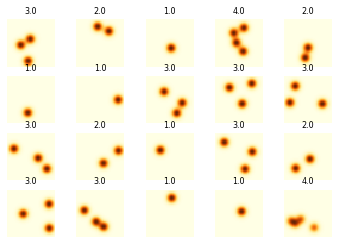

In [5]:
plotData(0, min(20, numTrain), trainInput, trainOutput)

## 2. Create the test data

In [6]:
# allocate memory
testInput = np.zeros((numTest, numCells, numCells), np.float32)
testOutput = np.zeros((numTest,), np.int8)
# fill in the data for each testing sample
for i in range(numTest):
  testInput[i, ...], testOutput[i] = generateRandomData(numCells, maxNumSpots)

Plotting a subset of test samples

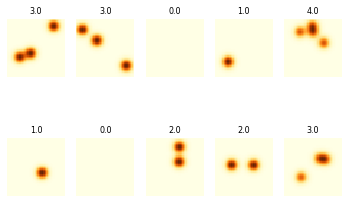

In [7]:
plotData(0, min(10, numTest), testInput, testOutput)
# shows spots and number of spots

## 3. Assemble the neural network and train it

We use Keras, a user friendly interface to TensorFlow and other tools. Below is one possible setup to solve our feature extraction problem -- feel free to play with the number of epochs, layers, filters, etc. Those feeling adventurous may want to try different layouts.

Because our problem involves pattern recognition, we start by building a convolution neural network. The neural network architecture consists of three groups of layers.

The 2D convolution layer applies different, 3x3 filters across the sample data. Each of the filters is trained to identify different patterns. The max pooling layer fires up a signal to the next level whenever there is a good match between a data region and the filter. 

The first pair of Conv2D/MaxPooling2D layers looks for patterns at the finest granularity. The next pair of Conv2D/MaxPooling2D layers searchs for patterns at coarser resolution. The patterns at high and low resolution might be different.

The second pair of Conv2D/MaxPooling2D layers feeds into a dense layer, which combines all the outputs of coarse filters shifted across the data to produce a single number representing the number of spots. That dense layer is equivalent to performing a linear regression. The output of the dense layer is a floating point number, like 3.2. We then round this number to the nearest integer to infer the number of spots (3).

In [8]:
from tensorflow import keras

# build the neural network
model = keras.Sequential()

# convolution 1
model.add( keras.layers.Conv2D(16, kernel_size=(3,3), strides=(1,1),
                             padding='same', data_format='channels_last', 
                             activation='relu') )
model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)) )

# convolution 2
model.add( keras.layers.Conv2D(16, kernel_size=(3,3), strides=(1,1),
                             padding='same', data_format='channels_last',
                             activation='relu') )
model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)) )


# add a dense layer with linear regression
model.add( keras.layers.Flatten() ) # from an "image" to a 1D array
model.add( keras.layers.Dense(4, activation='relu') )
model.add( keras.layers.Dense(1, activation='relu') ) # single output value

model.compile(optimizer='adam', loss='mean_squared_error',
            metrics=['accuracy'])

# now train 
numEpochs = 80 # number of times we pass the training dataset through the network
model.fit(trainInput.reshape(-1, numCells, numCells, 1), 
          trainOutput, epochs=numEpochs, batch_size=32)



Train on 1000 samples
Epoch 1/80
1000/1000 [==============================] - 2s 2ms/sample - loss: 2.3409 - accuracy: 0.2130
Epoch 2/80
1000/1000 [==============================] - 1s 901us/sample - loss: 0.5076 - accuracy: 0.3070
Epoch 3/80
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.4565 - accuracy: 0.3070
Epoch 4/80
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.4244 - accuracy: 0.3070
Epoch 5/80
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.4338 - accuracy: 0.3070
Epoch 6/80
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.4284 - accuracy: 0.3070
Epoch 7/80
1000/1000 [==============================] - 1s 785us/sample - loss: 0.4160 - accuracy: 0.3070
Epoch 8/80
1000/1000 [==============================] - 1s 671us/sample - loss: 0.4167 - accuracy: 0.3070
Epoch 9/80
1000/1000 [==============================] - 1s 702us/sample - loss: 0.4222 - accuracy: 0.3070
Epoch 10/80
1000/1000 [===========

In [9]:
# give a summary of the model 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  6404      
_________________________________________________________________
dense_1 (Dense)              multiple                  5

## 4.Test the accuracy using the test data

In [10]:
predictions = model.predict(testInput.reshape(-1, numCells, numCells, 1))[:, 0]
# compute the errors: difference between predictions and testOuput
errors = np.round(predictions) - testOutput
numErrors = (errors != 0).sum()
print(errors)
print('num errors = {} ({} %)'.format(numErrors, 100*numErrors/numTest))


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -1.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.
  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0. -1. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -2.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
num errors = 16 (8.0 %)



Plotting test samples for which the model gave a wrong number of spots

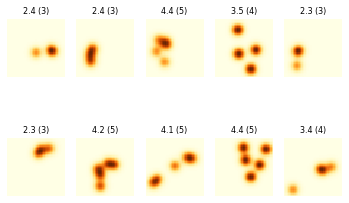

In [11]:
inds = np.nonzero(errors != 0)[0]
failuresInput = testInput[inds, :]
failuresOutput = predictions[inds]
correctOutput = testOutput[inds]
numFailures = len(failuresOutput)
plotData(0, min(10, numFailures), failuresInput, failuresOutput, correctOutput)

## Questions to ponder

  1. Does the neural network tend to over or under predict the number of spots?
  2. What is the most common reason of failure to predict the correct number of spots?
  3. List the parameters that can likely improve the predictions
  4. Try to improve the accuracy of the predictions
  
 Hey if you find a better solution, let me know so I can add it to the notebook! --Alex